In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import scipy.stats as sp

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import savefig

In [2]:
% matplotlib inline

In [3]:
sns.set(style='white')

In [4]:
source_dir = Path('..') / '..' / 'derivatives' / '0.4.joined'

In [5]:
data = pd.read_csv( source_dir / 'all_subject_level.csv' )
data['Condition'] = data['Condition'].replace({1:'Annotated',2:'Video',3:'Original'})
data['AgeGroup'] = data['AgeGroup'].replace({1:'YA',2:'OA'})
data['SciField'] = data['SciField'] - 1
data['Gender'] = data['Gender'] - 1
data['nb_CoR'] = data['nb_CoR']*100
data[['SciEdu_HS','SciEdu_UGrad','SciEdu_Grad']] = data[['SciEdu_HS','SciEdu_UGrad','SciEdu_Grad']].replace({np.nan:0})
data.head()

,sub,Condition,Age,Gender,Major,Major_TEXT,SciDegree,SciDegree_TEXT,EduYears,SciEdu_HS,...,SciLit_sum,SciTudeA_sum,SciTudeL_sum,SciTudeS_sum,O1_sum,O2_sum,O3_sum,O4_sum,O5_sum,O6_sum
0,101,Annotated,20.0,1.0,5.0,biomedical-science,NaN,NaN,14,4,...,4.0,25,21,24,9,14,17,9,12,13
1,102,Video,19.0,1.0,5.0,forensic-science,NaN,NaN,12,3,...,2.0,21,22,26,17,19,14,11,11,9
2,103,Original,18.0,0.0,2.0,communications,NaN,NaN,12,3,...,2.0,27,13,21,16,13,16,10,11,16
3,104,Annotated,18.0,0.0,5.0,statistics,NaN,NaN,12,4,...,2.0,30,20,27,17,13,20,14,15,13
4,105,Video,18.0,0.0,5.0,biomedical-science,NaN,NaN,12,6,...,4.0,21,13,28,17,13,12,12,10,13


# Demographics

In [6]:
df = data.groupby(['AgeGroup','Condition']).agg({
    'sub':'count', 'Age':'mean', 'Gender':'mean', 'SciField':'mean',
    'comp_change':'mean', 'comp_t1':'mean', 'comp_t2':'mean'
})
df

sub        Age    Gender  SciField  comp_change  \
AgeGroup Condition                                                    
OA       Annotated   18  71.400000  0.722222  0.722222     2.111111   
         Original    19  75.750000  0.736842  0.631579     3.526316   
         Video       20  74.105263  0.631579  0.650000     3.550000   
YA       Annotated   26  18.500000  0.653846  0.346154     2.730769   
         Original    28  18.851852  0.535714  0.285714     4.107143   
         Video       23  19.043478  0.652174  0.173913     3.826087   

                      comp_t1    comp_t2  
AgeGroup Condition                        
OA       Annotated  11.833333  13.944444  
         Original   10.842105  14.368421  
         Video      10.650000  14.200000  
YA       Annotated  10.576923  13.307692  
         Original    9.678571  13.785714  
         Video       9.782609  13.608696

# Group comparisons

In [7]:
vars_of_interest = ['comp_t1', 'comp_t2', 'comp_change', 'nb_CoR', 'nb_RT', 'procspd_RT',
                    'NFCS_sum','TSSI_sum', 'vocab_sum','SciLit_sum',
                    'SciTudeA_sum','SciTudeL_sum','SciTudeS_sum']

In [8]:
grps_of_interest = ['Condition','AgeGroup',['AgeGroup','Condition']]

# Correlations
We need to drop all missing data listwise. SPSS does this pairwise for the correlations, but I'm not sure how exactly to replicate that. If we find a way to, I would prefer not to destroy data unnecessarily here.

In [9]:
slim_data = data[['sub','AgeGroup','Condition']+vars_of_interest].dropna()

## Correlation Matrices

Define functions to create the correlation & significance tables and matrices

In [10]:
def corr_table(df):
    corr_df = pd.DataFrame()
    for c in vars_of_interest:
        for d in vars_of_interest:
            corr_df.loc[c,d] = sp.pearsonr(df[c],df[d])[0]
    return(corr_df)

def sig_table(df):
    sig_df = pd.DataFrame()
    for c in vars_of_interest:
        for d in vars_of_interest:
            sig_df.loc[c,d] = sp.pearsonr(df[c],df[d])[1]
    return(sig_df)

In [11]:
def matrix_mask(df):
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(16,5))
    return(mask)

In [12]:
def correlation_matrix(df,title):
    mask = matrix_mask(df)
    fig = sns.heatmap(df, mask=mask, annot=True, cmap='Spectral',
                      fmt='.3f', linewidths=1, center=0)
    fig.set_title(title+'\nCorrelation Coefficients')
    return(fig)

def significance_matrix(df,title):
    mask = matrix_mask(df)
    myColors = (
        (0.4, 0.0, 0.0, 1.00),(0.6, 0.0, 0.0, 0.85),(0.8, 0.0, 0.0, 0.70),(1.0, 0.0, 0.0, 0.55),
        (1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),
        (1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),
        (1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),
        (1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),
    )
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    fig = sns.heatmap(df, mask=mask, annot=True, cmap=cmap,
                fmt='.3f', linewidths=1, center=0.5
               )
    fig.set_title(title+'\nCorrelation Significance')
    return(fig)

### All AgeGroups,Conditions

In [13]:
corr_df = corr_table(slim_data)
sig_df = sig_table(slim_data)

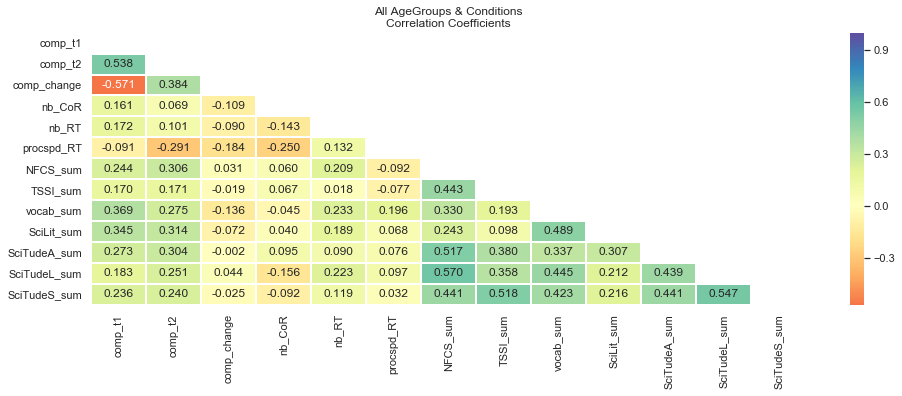

In [14]:
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_all.png'
fig = correlation_matrix(corr_df,'All AgeGroups & Conditions')
fig.get_figure().savefig(fpath, bbox_inches='tight')

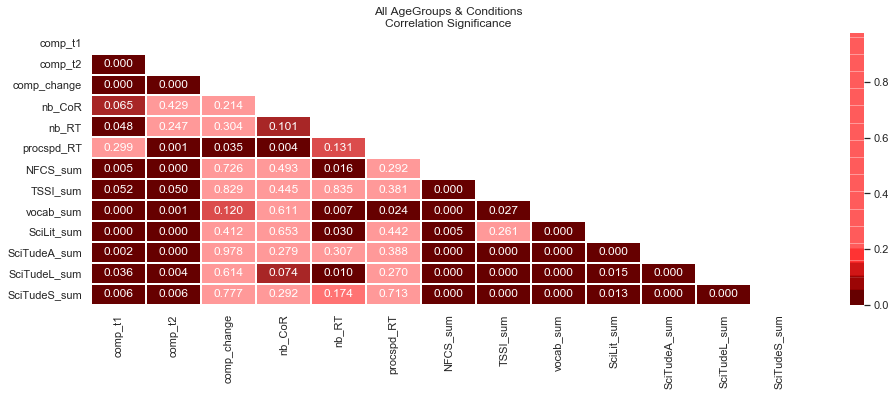

In [15]:
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_all.png'
fig = significance_matrix(sig_df,'All AgeGroups & Conditions')
fig.get_figure().savefig(fpath, bbox_inches='tight')

### By AgeGroup

In [16]:
ya_data = slim_data[slim_data['AgeGroup'] == 'YA']
oa_data = slim_data[slim_data['AgeGroup'] == 'OA']

In [17]:
ya_corr_df = corr_table(ya_data)
ya_sig_df = sig_table(ya_data)
oa_corr_df = corr_table(oa_data)
oa_sig_df = sig_table(oa_data)

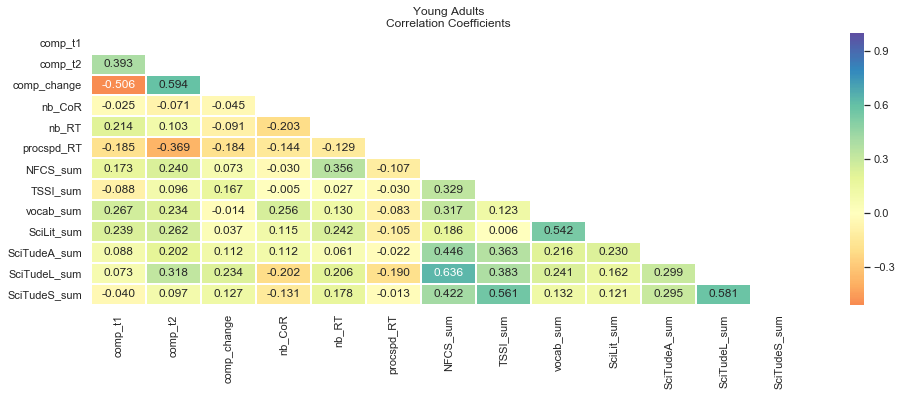

In [18]:
fig = correlation_matrix(ya_corr_df,'Young Adults')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_ya.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

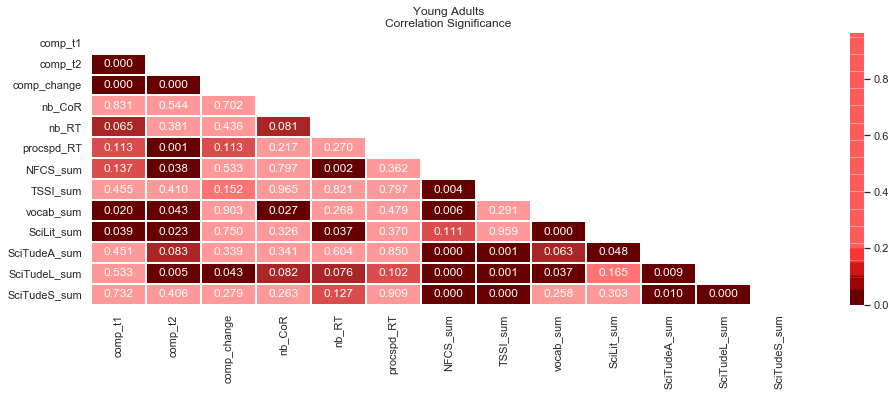

In [19]:
fig = significance_matrix(ya_sig_df,'Young Adults')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_ya.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

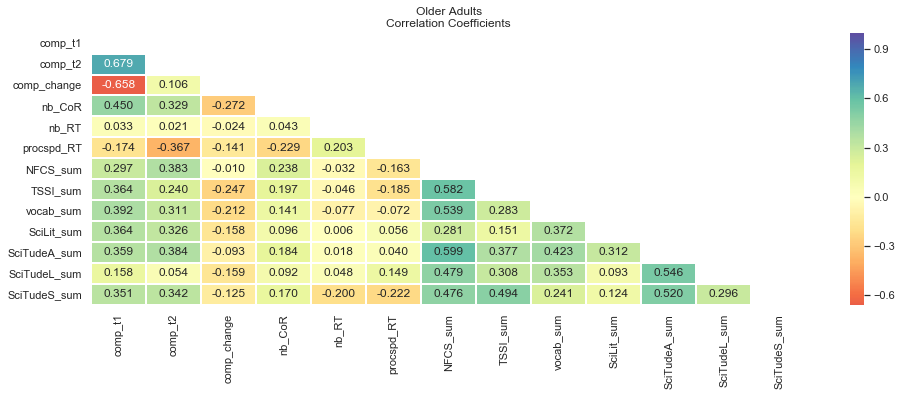

In [20]:
fig = correlation_matrix(oa_corr_df,'Older Adults')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_oa.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

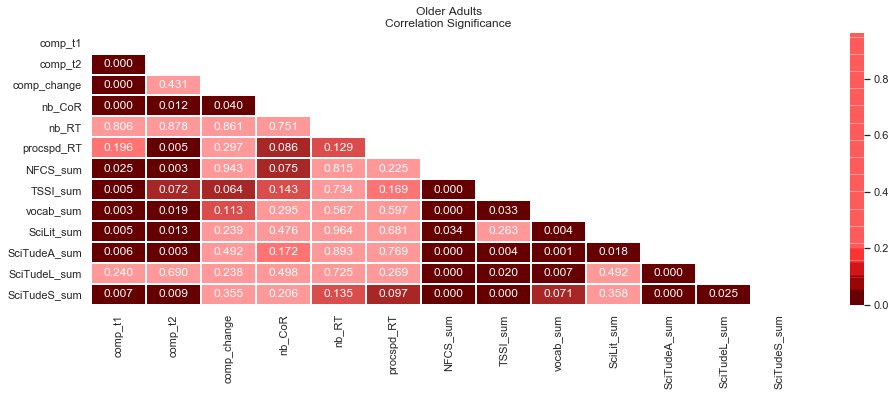

In [21]:
fig = significance_matrix(oa_sig_df,'Older Adults')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_oa.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

### By Condition

In [22]:
annotated_data = slim_data[slim_data['Condition'] == 'Annotated']
original_data = slim_data[slim_data['Condition'] == 'Original']
video_data = slim_data[slim_data['Condition'] == 'Video']

In [23]:
annotated_corr_df = corr_table(annotated_data)
annotated_sig_df = sig_table(annotated_data)

original_corr_df = corr_table(original_data)
original_sig_df = sig_table(original_data)

video_corr_df = corr_table(video_data)
video_sig_df = sig_table(video_data)

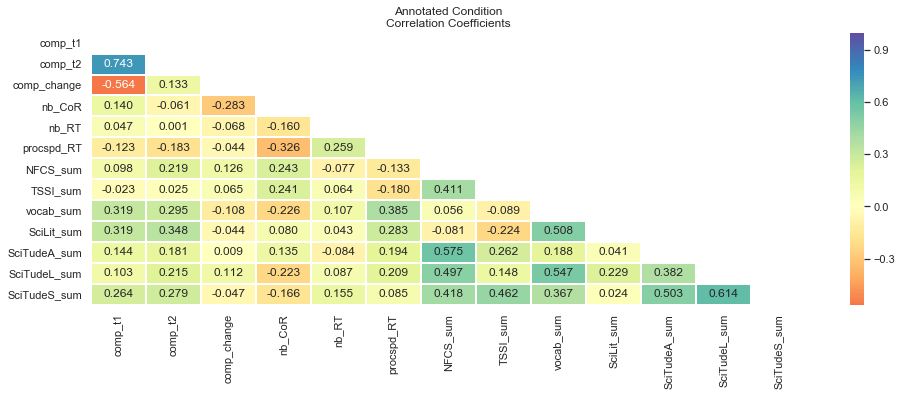

In [24]:
fig = correlation_matrix(annotated_corr_df,'Annotated Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_annot.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

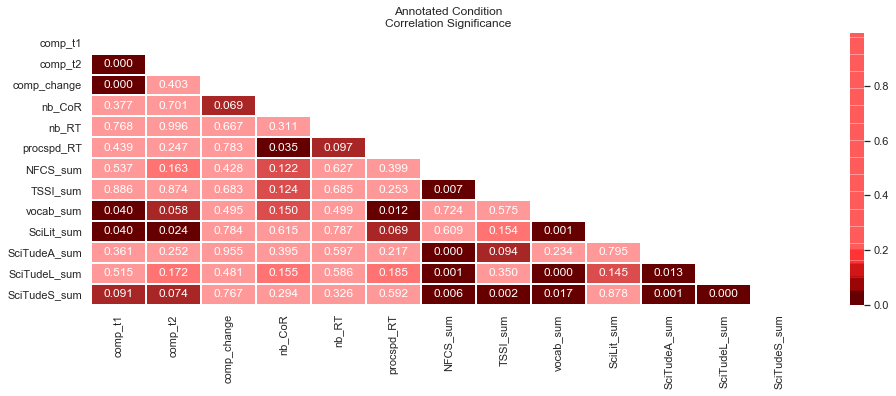

In [25]:
fig = significance_matrix(annotated_sig_df,'Annotated Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_annot.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

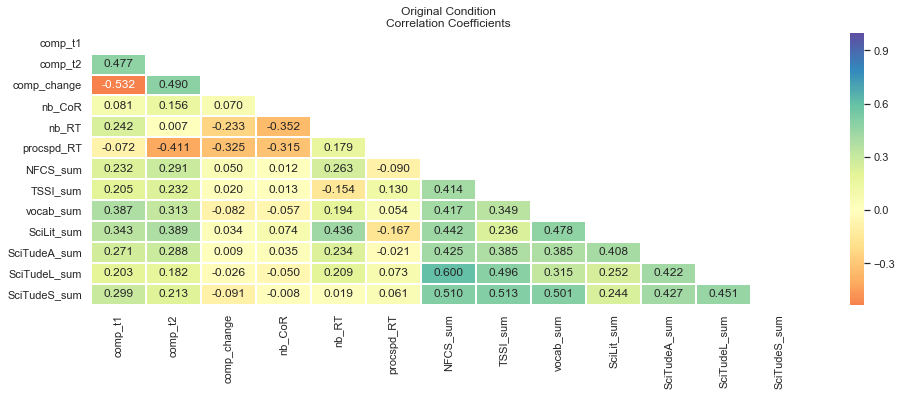

In [26]:
fig = correlation_matrix(original_corr_df,'Original Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_orig.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

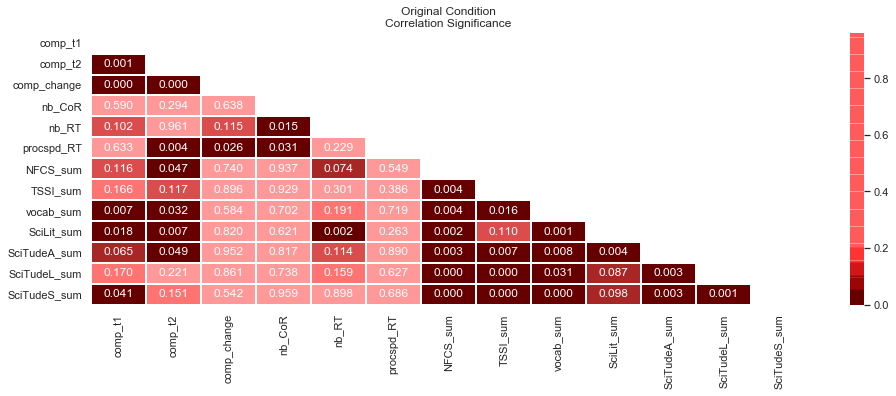

In [27]:
fig = significance_matrix(original_sig_df,'Original Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_orig.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

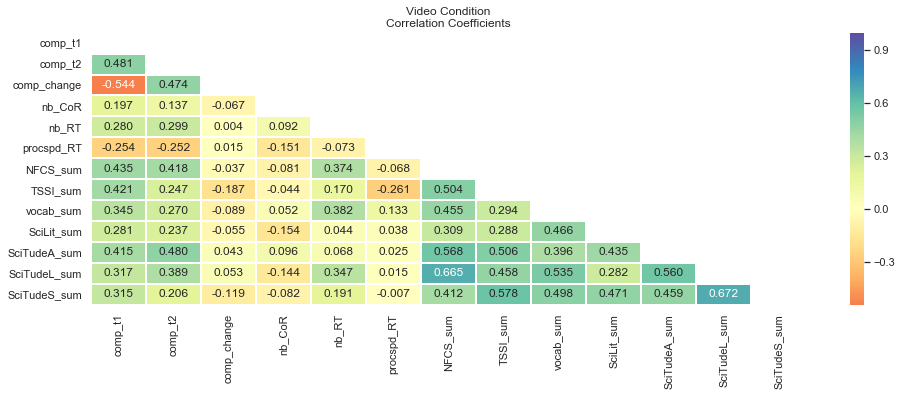

In [28]:
fig = correlation_matrix(video_corr_df,'Video Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_video.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

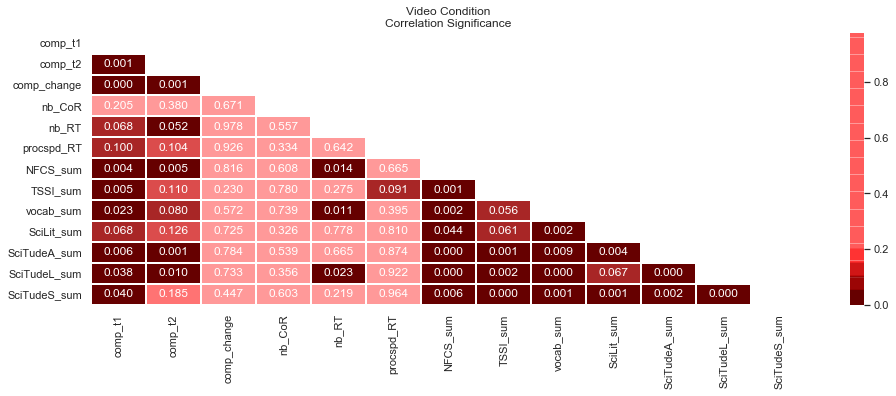

In [29]:
fig = significance_matrix(video_sig_df,'Video Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_video.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

## Correlograms

<Figure size 1152x360 with 0 Axes>

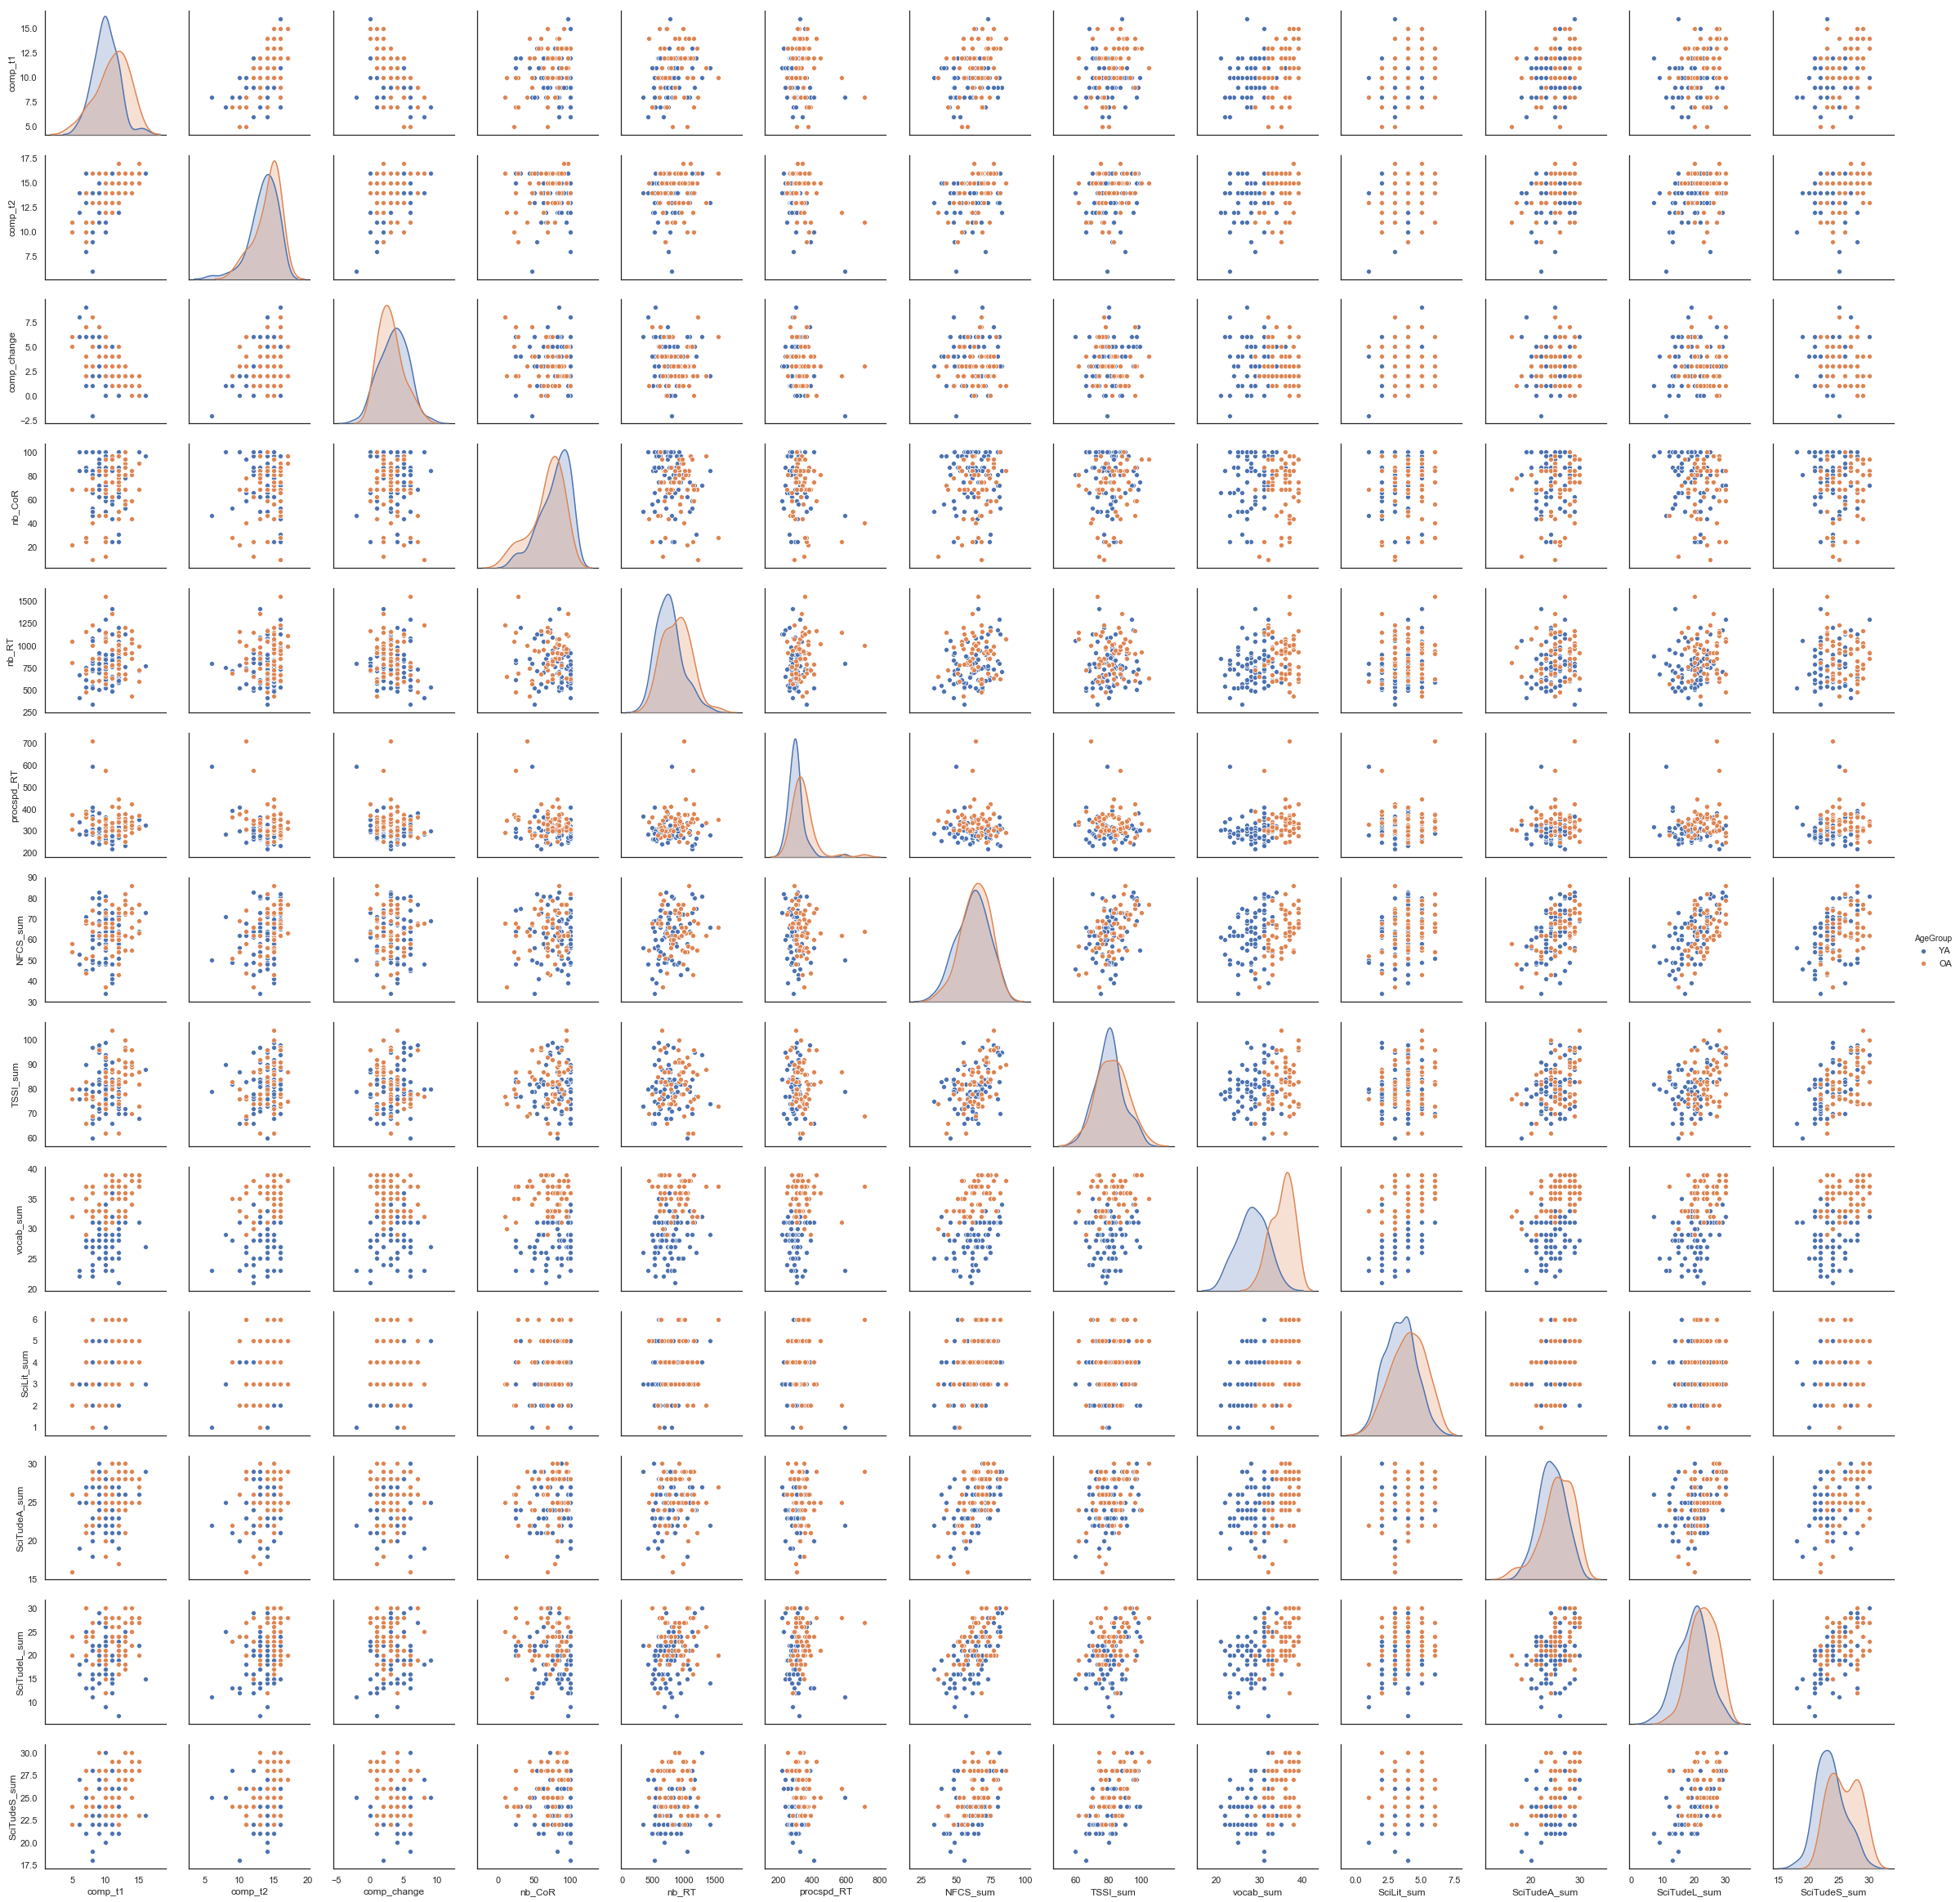

In [30]:
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'correlogram_AgeGroup.png'
plt.figure(figsize=(16,5))
df = slim_data[vars_of_interest+['AgeGroup','Condition']]
fig = sns.pairplot(df,hue='AgeGroup')
# for i,j in zip(*np.triu_indices_from(fig.axes, 1)):
#     fig.axes[i, j].set_visible(False)
fig.savefig(fpath, bbox_inches='tight')

<Figure size 1152x360 with 0 Axes>

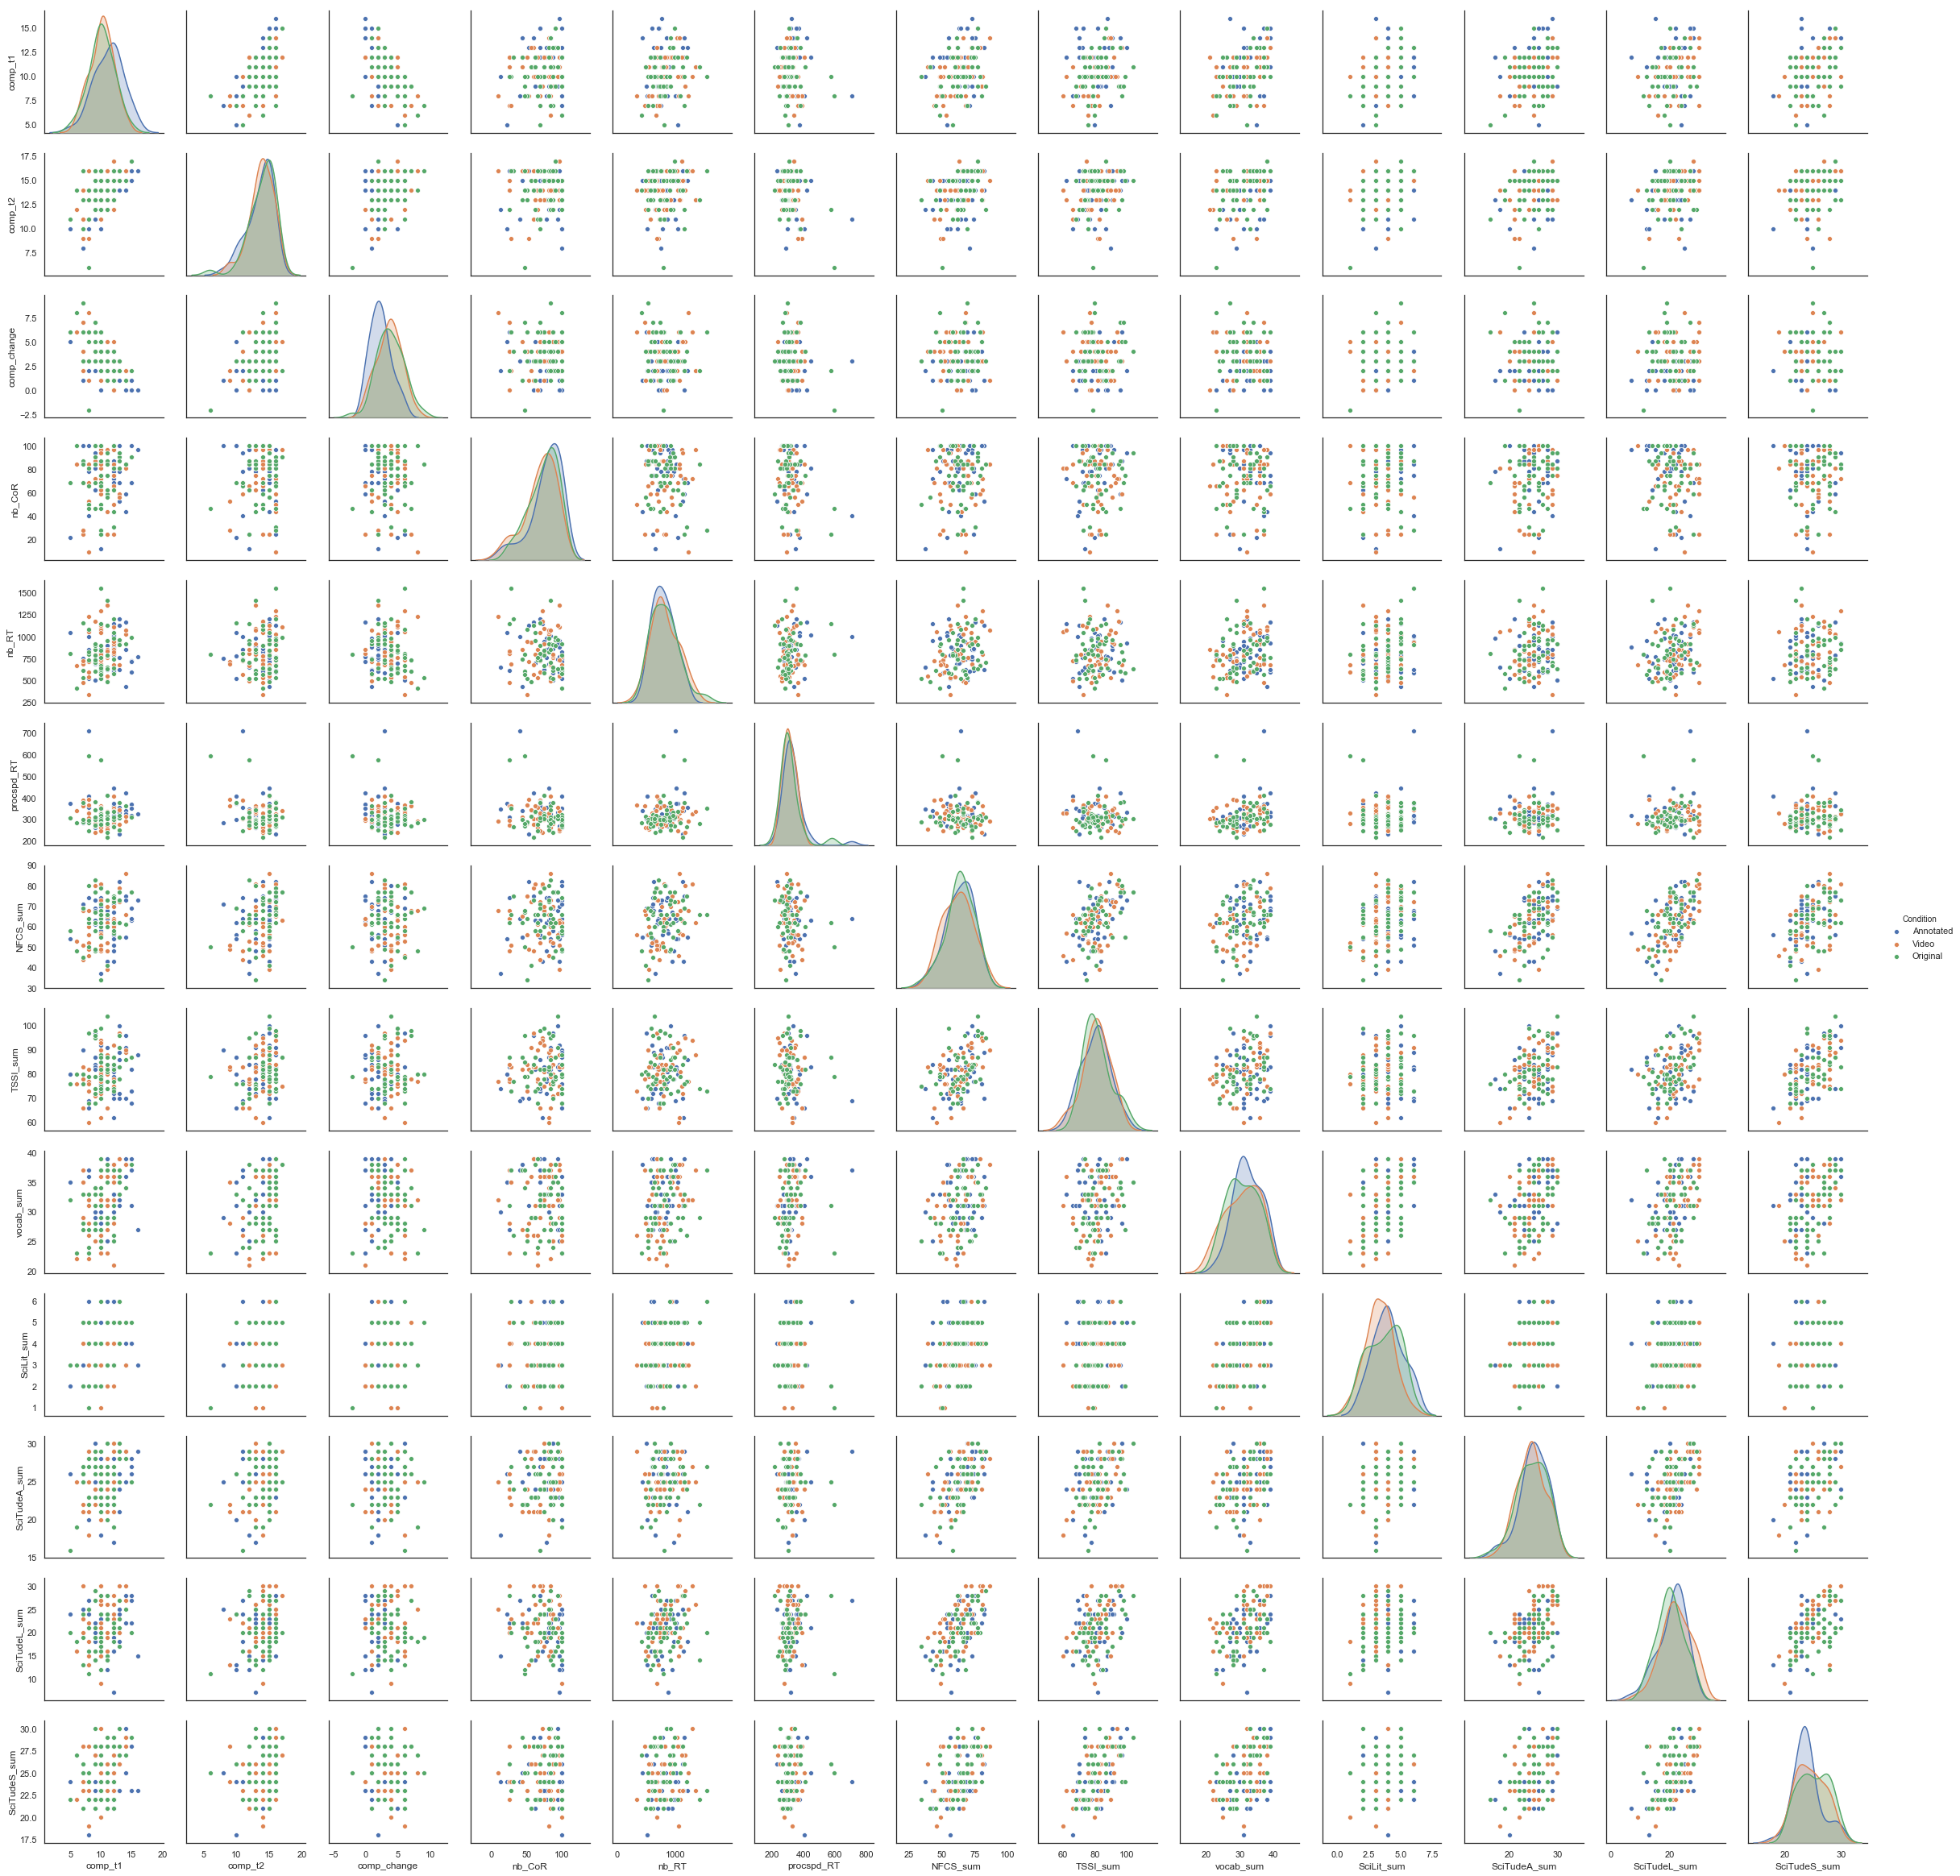

In [31]:
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'correlogram_Condition.png'
plt.figure(figsize=(16,5))
df = slim_data[vars_of_interest+['AgeGroup','Condition']]
fig = sns.pairplot(df,hue='Condition')
# for i,j in zip(*np.triu_indices_from(fig.axes, 1)):
#     fig.axes[i, j].set_visible(False)
fig.savefig(fpath, bbox_inches='tight')

# Vertical Bar plots

# Horizontal Swarm, Strip, Box, Bar plots

..\..\derivatives\figures\comp_t1_Condition_swarm
..\..\derivatives\figures\comp_t2_Condition_swarm
..\..\derivatives\figures\comp_change_Condition_swarm
..\..\derivatives\figures\nb_CoR_Condition_swarm
..\..\derivatives\figures\nb_RT_Condition_swarm
..\..\derivatives\figures\procspd_RT_Condition_swarm
..\..\derivatives\figures\NFCS_sum_Condition_swarm
..\..\derivatives\figures\TSSI_sum_Condition_swarm
..\..\derivatives\figures\vocab_sum_Condition_swarm
..\..\derivatives\figures\SciLit_sum_Condition_swarm
..\..\derivatives\figures\SciTudeA_sum_Condition_swarm
..\..\derivatives\figures\SciTudeL_sum_Condition_swarm
..\..\derivatives\figures\SciTudeS_sum_Condition_swarm
..\..\derivatives\figures\comp_t1_AgeGroup_swarm
..\..\derivatives\figures\comp_t2_AgeGroup_swarm
..\..\derivatives\figures\comp_change_AgeGroup_swarm
..\..\derivatives\figures\nb_CoR_AgeGroup_swarm
..\..\derivatives\figures\nb_RT_AgeGroup_swarm
..\..\derivatives\figures\procspd_RT_AgeGroup_swarm
..\..\derivatives\figures\

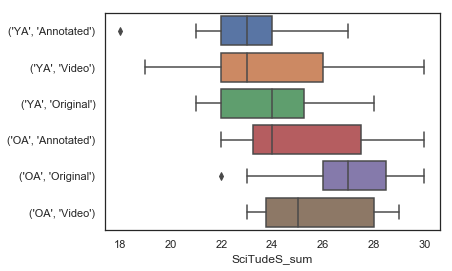

In [33]:
plots_dict = { 'swarm':sns.swarmplot, 'box':sns.boxplot }
for plot in plots_dict.keys():
    for grp in grps_of_interest:
        for var in vars_of_interest:
            try: fig.clear()
            except AttributeError as e: fig=None
            
            fname = var +'_'+ ''.join(grp) +'_'+ plot
            fpath = Path('..') / '..' / 'derivatives' / 'figures' / fname
            print(fpath)
            
            df = slim_data.set_index(grp)
            fig = plots_dict[plot](x=var, y=df.index, data=df)
            fig.get_figure().savefig(fpath, bbox_inches='tight')